In [1]:
import numpy as np
from collections import Counter
import pandas as pd
import time

In [2]:
class KNNClassifier:
    def __init__(self, k=5, distance='euclidean', p=3):
        self.k = k
        self.distance = distance
        self.p = p  # Usado apenas para Minkowski

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def _compute_distance(self, x1, x2):
        if self.distance == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.distance == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        elif self.distance == 'minkowski':
            return np.sum(np.abs(x1 - x2) ** self.p) ** (1 / self.p)
        elif self.distance == 'chebyshev':
            return np.max(np.abs(x1 - x2))
        else:
            raise ValueError(f"Distância '{self.distance}' não suportada.")

    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            distances = np.array([self._compute_distance(x, x_train) for x_train in self.X_train])

            k_nearest_indices = np.argsort(distances)[:self.k]

            k_nearest_labels = self.y_train[k_nearest_indices]
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            y_pred.append(most_common)

        return np.array(y_pred)


In [12]:
import numpy as np

class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000, lambda_l1=0.0, lambda_l2=0.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2
        self.weights = None
        self.bias = None
        self.classes_ = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        
        # Inicializa pesos e bias para cada classe (One-vs-Rest)
        self.weights = np.zeros((len(self.classes_), n_features))
        self.bias = np.zeros(len(self.classes_))

        for idx, cls in enumerate(self.classes_):
            y_binary = np.where(y == cls, 1, 0)
            w = np.zeros(n_features)
            b = 0

            for _ in range(self.epochs):
                linear_model = np.dot(X, w) + b
                y_predicted = self._sigmoid(linear_model)

                dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y_binary))
                db = (1 / n_samples) * np.sum(y_predicted - y_binary)

                dw += self.lambda_l2 * w
                dw += self.lambda_l1 * np.sign(w)

                w -= self.learning_rate * dw
                b -= self.learning_rate * db

            self.weights[idx, :] = w
            self.bias[idx] = b

        return self
        

    def predict_proba(self, X):
        linear_models = np.dot(X, self.weights.T) + self.bias
        return self._sigmoid(linear_models)

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]


In [4]:
# validações: holdout, holdout repetido, k-fold, k-fold estratificado, Leave-one-out (LOOCV), Bootstrap e Bootstrap Reduzido.

def holdout_validation(X, y, model_class, metric, test_size=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split = int(len(X) * (1 - test_size))
    train_idx, test_idx = indices[:split], indices[split:]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = model_class()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metric(y_test, y_pred)

def repeated_holdout(X, y, model_class, metric, test_size=0.3, n_repeats=5, seed=None):
    scores = []
    for i in range(n_repeats):
        current_seed = None if seed is None else seed + i
        score = holdout_validation(X, y, model_class, metric, test_size, current_seed)
        scores.append(score)
    return np.mean(scores)

def k_fold_validation(X, y, model_class, metric, k=5):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_sizes = np.full(k, len(X) // k)
    fold_sizes[:len(X) % k] += 1
    current = 0
    scores = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_idx = indices[start:stop]
        train_idx = np.concatenate((indices[:start], indices[stop:]))
        model = model_class()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        scores.append(metric(y[test_idx], y_pred))
        current = stop
    return np.mean(scores)

def stratified_k_fold_validation(X, y, model_class, metric, k=5):
    from collections import defaultdict
    y = np.array(y)
    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[label].append(idx)

    folds = [[] for _ in range(k)]
    for idx_list in class_indices.values():
        np.random.shuffle(idx_list)
        for i, idx in enumerate(idx_list):
            folds[i % k].append(idx)

    scores = []
    for i in range(k):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for fold in folds if fold is not folds[i] for idx in fold])
        model = model_class()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        scores.append(metric(y[test_idx], y_pred))
    return np.mean(scores)

def loocv_validation(X, y, model_class, metric):
    n = len(X)
    scores = []
    for i in range(n):
        train_idx = np.delete(np.arange(n), i)
        test_idx = i
        model = model_class()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict([X[test_idx]])
        scores.append(metric([y[test_idx]], y_pred))
    return np.mean(scores)

def bootstrap_validation(X, y, model_class, metric, n_iterations=100, seed=None):
    n = len(X)
    np.random.seed(seed)
    scores = []
    for _ in range(n_iterations):
        train_idx = np.random.choice(n, n, replace=True)
        test_idx = np.setdiff1d(np.arange(n), train_idx)
        if len(test_idx) == 0:
            continue
        model = model_class()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        scores.append(metric(y[test_idx], y_pred))
    return np.mean(scores)

def reduced_bootstrap_validation(X, y, model_class, metric, n_iterations=100, train_frac=0.5, seed=None):
    n = len(X)
    np.random.seed(seed)
    scores = []
    train_size = int(train_frac * n)
    for _ in range(n_iterations):
        train_idx = np.random.choice(n, train_size, replace=True)
        test_idx = np.setdiff1d(np.arange(n), train_idx)
        if len(test_idx) == 0:
            continue
        model = model_class()
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        scores.append(metric(y[test_idx], y_pred))
    return np.mean(scores)


In [5]:
# Métricas de perfomace: Accuracia balanceada e F1-score macro

def compute_f1_macro(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    classes = np.unique(np.concatenate((y_true, y_pred)))
    n_classes = len(classes)

    recall_list = []
    f1_list = []

    for cls in classes:
        # Verdadeiros Positivos, Falsos Positivos, Falsos Negativos
        tp = np.sum((y_pred == cls) & (y_true == cls))
        fp = np.sum((y_pred == cls) & (y_true != cls))
        fn = np.sum((y_pred != cls) & (y_true == cls))
        tn = np.sum((y_pred != cls) & (y_true != cls))

        # Recall (Sensibilidade)
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        recall_list.append(recall)

        # Precisão
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

        # F1-Score
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        f1_list.append(f1)

    # F1-score macro: média dos F1 por classe
    f1_macro = np.mean(f1_list)

    return f1_macro


In [13]:
# Para o KNN
knn_param_grid = {
    "k": [3, 5, 7, 9, 11],
    "distance": ["euclidean", "manhattan", "minkowski", "chebyshev"]
}

# Para Regressão Logística
logreg_param_grid = {
    "learning_rate": [0.001, 0.01, 0.1],
    'lambda_l1': [0.001, 0.01, 0.1],
    'lambda_l2': [0.001, 0.01, 0.1]
}


In [7]:
def tune_model(model_class, param_grid, X, y, validation_fn, metric):
    from itertools import product

    param_names = list(param_grid.keys())
    param_combinations = list(product(*param_grid.values()))
    best_score = -np.inf
    best_params = None

    for combo in param_combinations:
        params = dict(zip(param_names, combo))
        model_fn = lambda: model_class(**params)
        score = validation_fn(X, y, model_fn, metric)
        if score > best_score:
            best_score = score
            best_params = params

    return best_params, best_score


In [16]:
# Lista de métodos de validação
validation_methods = {
    "Holdout": lambda X, y, m, metric: holdout_validation(X, y, m, metric, test_size=0.3, seed=42),
    "K-Fold": lambda X, y, m, metric: k_fold_validation(X, y, m, metric, k=5),
    "Bootstrap": lambda X, y, m, metric: bootstrap_validation(X, y, m, metric, n_iterations=50, seed=42),
    "LOOCV": lambda X, y, m, metric: loocv_validation(X, y, m, metric),
}

# Métricas (funções)
metrics = {
    "F1 Macro": compute_f1_macro, 
}


   Variável     F-score        p-valor
14      V15  654.251351   0.000000e+00
19      V20  347.463200  1.758605e-206
18      V19  301.137412  6.738630e-181
23      V24  226.003415  3.348200e-138
17      V18  209.145612  2.077623e-128
16      V17  208.298157  6.485938e-128
8        V9  162.584897  6.118781e-101
22      V23  161.722474  2.001728e-100
6        V7  154.311647   5.415176e-96
0        V1  137.948461   3.780678e-86
5        V6  110.460497   1.968778e-69
4        V5  103.215302   5.471895e-65
12      V13  100.752109   1.788832e-63
13      V14  100.035368   4.938356e-63
10      V11   91.962786   4.691623e-58
9       V10   91.165886   1.458042e-57
20      V21   81.637308   1.165932e-51
11      V12   72.928107   3.058458e-46
7        V8   72.340934   7.106223e-46
15      V16   59.921262   4.161241e-38
21      V22   48.679056   4.865683e-31
2        V3   41.621422   1.382402e-26
3        V4   40.735732   5.015707e-26
1        V2    5.095959   1.601462e-03


C:\Users\renan\AppData\Local\Temp\ipykernel_21284\3920157379.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-score', y='Variável', data=anova_scores, palette='viridis')


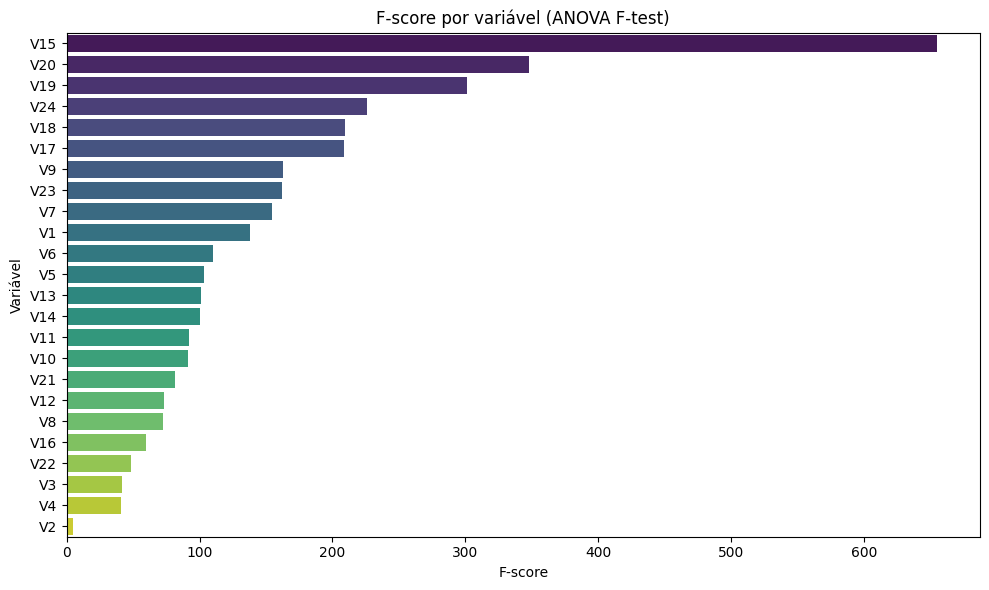

In [9]:
# Carrega o DataFrame
df = pd.read_csv('C:/Users/renan/Documents/Trab3/Robo.csv')
feature_names = df.drop(columns=['id', 'Class']).columns  # <- salve os nomes aqui
X = df.drop(columns=['id', 'Class']).values
y = df['Class'].values

# Padronização manual
means = X.mean(axis=0)
stds = X.std(axis=0)
stds[stds == 0] = 1
X = (X - means) / stds

# Aplica ANOVA F-test
from sklearn.feature_selection import SelectKBest, f_classif

anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X, y)

# Cria DataFrame com os resultados
anova_scores = pd.DataFrame({
    'Variável': feature_names,
    'F-score': anova_selector.scores_,
    'p-valor': anova_selector.pvalues_
}).sort_values(by='F-score', ascending=False)


# Exibe os resultados ordenados
print(anova_scores)

import matplotlib.pyplot as plt
import seaborn as sns

# Plota os F-scores
plt.figure(figsize=(10, 6))
sns.barplot(x='F-score', y='Variável', data=anova_scores, palette='viridis')
plt.title('F-score por variável (ANOVA F-test)')
plt.xlabel('F-score')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


In [10]:

# Carregamento do dataset
df = pd.read_csv('C:/Users/renan/Documents/Trab3/Robo.csv')
X_full = df.drop(columns=['id', 'Class'])
y = df['Class']

# Padronização manual
means = X_full.mean(axis=0)
stds = X_full.std(axis=0)
stds[stds == 0] = 1
X_full = (X_full - means) / stds

# Seleciona as top 10 variáveis com ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
X_top10 = selector.fit_transform(X_full, y)

# Pega os F-scores e p-valores
anova_scores = pd.DataFrame({
    'Variável': X_full.columns,
    'F-score': selector.scores_,
    'p-valor': selector.pvalues_
}).sort_values(by='F-score', ascending=False)

print(anova_scores.head(10))  # Top 10 variáveis com maior F-score



   Variável     F-score        p-valor
14      V15  654.251351   0.000000e+00
19      V20  347.463200  1.758605e-206
18      V19  301.137412  6.738630e-181
23      V24  226.003415  3.348200e-138
17      V18  209.145612  2.077623e-128
16      V17  208.298157  6.485938e-128
8        V9  162.584897  6.118781e-101
22      V23  161.722474  2.001728e-100
6        V7  154.311647   5.415176e-96
0        V1  137.948461   3.780678e-86


In [ ]:
results = []

for val_name, val_fn in validation_methods.items():
    for metric_name, metric_fn in metrics.items():
        # --- Tuning para Regressão Logística ---
        start_log = time.time()
        log_best_params, log_best_score = tune_model(LogisticRegression, logreg_param_grid, X_top10, y, val_fn, metric_fn)
        end_log = time.time()
        log_time = end_log - start_log

        results.append({
            "Validação": val_name,
            "Métrica": metric_name,
            "Modelo": "LogisticRegression",
            "Melhores Params": log_best_params,
            "Score": log_best_score,
            "Tempo (s)": round(log_time, 2)
        })
        print(results[-1])

{'Validação': 'Holdout', 'Métrica': 'F1 Macro', 'Modelo': 'LogisticRegression', 'Melhores Params': {'learning_rate': 0.1, 'lambda_l1': 0.001, 'lambda_l2': 0.001}, 'Score': 0.5580838838088898, 'Tempo (s)': 22.6}
{'Validação': 'K-Fold', 'Métrica': 'F1 Macro', 'Modelo': 'LogisticRegression', 'Melhores Params': {'learning_rate': 0.1, 'lambda_l1': 0.001, 'lambda_l2': 0.001}, 'Score': 0.5492695234775822, 'Tempo (s)': 132.85}
{'Validação': 'Bootstrap', 'Métrica': 'F1 Macro', 'Modelo': 'LogisticRegression', 'Melhores Params': {'learning_rate': 0.1, 'lambda_l1': 0.001, 'lambda_l2': 0.001}, 'Score': 0.548095079208764, 'Tempo (s)': 1436.26}


In [ ]:
for r in results:
    print(f"{r['Validação']} | {r['Métrica']} | {r['Modelo']}:")
    print(f"  Melhores Parâmetros: {r['Melhores Params']}")
    print(f"Métrica: {r['Métrica']}")
    print(f"  Score: {r['Score']:.4f}")
    print(f"  Tempo: {r['Tempo (s)']} segundos")
    print("-" * 50)


In [ ]:
for val_name, val_fn in validation_methods.items():
    for metric_name, metric_fn in metrics.items():
        # --- Tuning para KNN ---
        start_knn = time.time()
        knn_best_params, knn_best_score = tune_model(KNNClassifier, knn_param_grid, X_top10, y, val_fn, metric_fn)
        end_knn = time.time()
        knn_time = end_knn - start_knn

        results.append({
            "Validação": val_name,
            "Métrica": metric_name,
            "Modelo": "KNN",
            "Melhores Params": knn_best_params,
            "Score": knn_best_score,
            "Tempo (s)": round(knn_time, 2)
        })

In [ ]:
for r in results:
    print(f"{r['Validação']} | {r['Métrica']} | {r['Modelo']}:")
    print(f"  Melhores Parâmetros: {r['Melhores Params']}")
    print(f"Métrica: {r['Métrica']}")
    print(f"  Score: {r['Score']:.4f}")
    print(f"  Tempo: {r['Tempo (s)']} segundos")
    print("-" * 50)


Holdout | F1 Macro | LogisticRegression:
  Melhores Parâmetros: {'learning_rate': 0.001, 'epochs': 500}
Métrica: F1 Macro
  Score: 0.1460
  Tempo: 2.03 segundos
--------------------------------------------------
Holdout Repetido | F1 Macro | LogisticRegression:
  Melhores Parâmetros: {'learning_rate': 0.001, 'epochs': 500}
Métrica: F1 Macro
  Score: 0.1447
  Tempo: 10.15 segundos
--------------------------------------------------
K-Fold | F1 Macro | LogisticRegression:
  Melhores Parâmetros: {'learning_rate': 0.001, 'epochs': 2000}
Métrica: F1 Macro
  Score: 0.1439
  Tempo: 11.36 segundos
--------------------------------------------------
K-Fold Estratificado | F1 Macro | LogisticRegression:
  Melhores Parâmetros: {'learning_rate': 0.001, 'epochs': 500}
Métrica: F1 Macro
  Score: 0.1439
  Tempo: 12.77 segundos
--------------------------------------------------
LOOCV | F1 Macro | LogisticRegression:
  Melhores Parâmetros: {'learning_rate': 0.001, 'epochs': 500}
Métrica: F1 Macro
  Score